# Evaluation of v2.2 Hydrofabric
## Author: Tadd Bindas

The goal of this notebook is to show that v2.2 of the enterprise hydrofabric works. The first part of the notebook preps the mapping of forcings between the v20 sample data and the v2.2 new HYFeatures IDs. From there, the notebook runs, then plots the output

#### Step 0: Read domain files and find mappings

In [ ]:
from pathlib import Path

import geopandas as gpd
import numpy as np

import pandas as pd


In [21]:
v20 = gpd.read_file(Path.cwd() / "../LowerColorado_TX_v4/domain/LowerColorado_NGEN_v201.gpkg", layer="flowpaths")
v22 = gpd.read_file(Path.cwd() / "domain/LowerColorado_v22_no_lakes.gpkg", layer="flowpaths")


Since the new v2.2 and v20.1 have different IDs, we need to map the flow from the old forcings to the new forcings

In [71]:
intersections = gpd.overlay(v20, v22, how='intersection')

intersections['intersection_area'] = intersections.geometry.area

match_df = (intersections
          .sort_values('intersection_area', ascending=False)
          .groupby('id_1')
          .first()
          .reset_index())

mapping = {int(row["id_1"].split("-")[1]): int(row["id_2"].split("-")[1]) for _, row in match_df.iterrows()}



/tmp/ipykernel_3676960/445097577.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 86089 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersections = gpd.overlay(v20, v22, how='intersection')


In [72]:
domain_file = pd.read_csv(Path.cwd() / "../LowerColorado_TX_v4/channel_forcing/202304021100.CHRTOUT_DOMAIN1.csv")
feature_ids = np.sort(domain_file["feature_id"].values)
mapping_keys = list(mapping.keys())

# Filter feature_ids to only include those in mapping.keys(), then sort them. This only has to be done once as the domain files all should have the same forcings
filtered_feature_ids = feature_ids[np.isin(feature_ids, mapping_keys)]
sorted_filtered_feature_ids = np.sort(filtered_feature_ids)


In [75]:
inputs_path = Path.cwd() / "../LowerColorado_TX_v4/channel_forcing"
outputs_path = Path.cwd() / "channel_forcing"
for file in inputs_path.glob("*.csv"):
    feature_ids = []
    values = []
    _df = pd.read_csv(file)
    time_col = _df.columns[-1]
    sorted_df = _df.sort_values("feature_id").reset_index(drop=False) 

    matching_indices = np.where(np.isin(sorted_df["feature_id"].values, sorted_filtered_feature_ids))[0]
    mapped_ids = np.array([mapping[_id] for _id in sorted_df["feature_id"].values[matching_indices]])
    mapped_values = sorted_df[time_col].values[matching_indices]

    unique_indices = np.unique(mapped_ids, return_index=True)[1]
    mapped_ids = mapped_ids[unique_indices]
    mapped_values = mapped_values[unique_indices]

    df = pd.DataFrame({
        "feature_id": mapped_ids,
        time_col: mapped_values,
    })
    output_file = outputs_path / file.name
    df.to_csv(output_file, index=False)


Now that the forcings have been generated, let's run the routing code

In [94]:
# Running the v20.1 T-route code
import os
os.chdir("../LowerColorado_TX_v4")
!python -m nwm_routing -f -V4 test_AnA_V4_HYFeature_noDA.yaml
os.chdir("../LowerColorado_TX_HYFeatures_v22")


/home/tadd.bindas/miniforge3/lib/python3.10/runpy.py:126: RuntimeWarning: 'nwm_routing.__main__' found in sys.modules after import of package 'nwm_routing', but prior to execution of 'nwm_routing.__main__'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
creating supernetwork connections set
2024-11-25 18:22:38,828 - fiona._env - DEBUG - [env.py:315 - defenv]: GDAL data found in package: path='/home/tadd.bindas/github/t-route/.venv/lib/python3.10/site-packages/fiona/gdal_data'.
2024-11-25 18:22:38,829 - fiona._env - DEBUG - [env.py:315 - defenv]: PROJ data found in package: path='/home/tadd.bindas/github/t-route/.venv/lib/python3.10/site-packages/fiona/proj_data'.
supernetwork connections set complete
... in 3.5333192348480225 seconds.
2024-11-25 18:22:42,362 - root - INFO - [AbstractNetwork.py:525 - create_independent_networks]: organizing connections into reaches ...
2024-11-25 18:22:42,398 - root - DEBUG - [AbstractNetwork.py:554 - create_independent_networks]

In [96]:
# Running the v2.2 T-route code
!python -m nwm_routing -f -V4 test_AnA_V4_HYFeature_v22.yaml


/home/tadd.bindas/miniforge3/lib/python3.10/runpy.py:126: RuntimeWarning: 'nwm_routing.__main__' found in sys.modules after import of package 'nwm_routing', but prior to execution of 'nwm_routing.__main__'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
creating supernetwork connections set
2024-11-25 18:23:54,178 - fiona._env - DEBUG - [env.py:315 - defenv]: GDAL data found in package: path='/home/tadd.bindas/github/t-route/.venv/lib/python3.10/site-packages/fiona/gdal_data'.
2024-11-25 18:23:54,179 - fiona._env - DEBUG - [env.py:315 - defenv]: PROJ data found in package: path='/home/tadd.bindas/github/t-route/.venv/lib/python3.10/site-packages/fiona/proj_data'.
supernetwork connections set complete
... in 3.820676326751709 seconds.
2024-11-25 18:23:57,997 - root - INFO - [AbstractNetwork.py:525 - create_independent_networks]: organizing connections into reaches ...
2024-11-25 18:23:58,017 - root - DEBUG - [AbstractNetwork.py:554 - create_independent_networks]:

#### Step 1: Plotting the v2.2 outputs vs the v20.1 outputs

In [99]:
from pathlib import Path

import xarray as xr

v22_flow = xr.open_dataset(Path.cwd() / "output/troute_output_202304020000.nc", engine="netcdf4")
v20_flow = xr.open_dataset(Path.cwd() / "../LowerColorado_TX_v4/output/troute_output_202304020000.nc", engine="netcdf4")


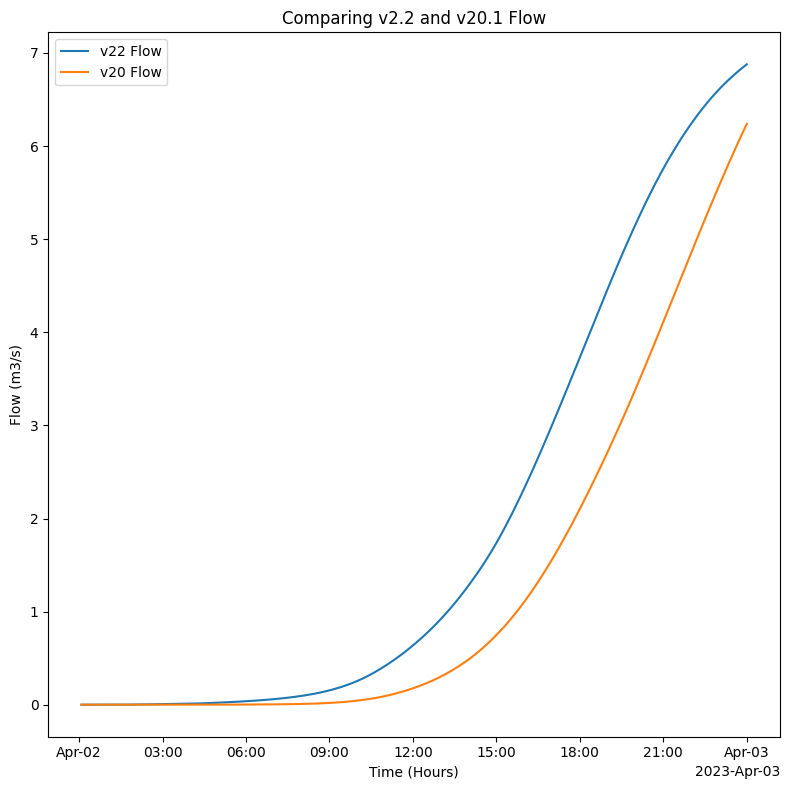

In [100]:
import matplotlib.pyplot as plt

v20_outflow_id = 2421104
v22_outflow_id = 2430686

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

v22_flow.sel(feature_id=v22_outflow_id).sel(time=slice("2023-04-02", "2023-04-03")).flow.plot(ax=ax, label='v22 Flow')
v20_flow.sel(feature_id=v20_outflow_id).sel(time=slice("2023-04-02", "2023-04-03")).flow.plot(ax=ax, label='v20 Flow')
ax.set_title('Comparing v2.2 and v20.1 Flow')
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Flow (m3/s)')
ax.legend()

plt.tight_layout()

plt.show()


Given the forcings from the IDS are no mapped 1 to 1 perfectly, and the flowlines / nexus connectivity graphs are different, and Manning's roughness values, seeing a similar rise from the forcings and parallel slope timing indicates v2.2 is working successfully